# 공항 온실가스 배출량 변화 요인 산출 및 제언-항공 노선 운항 편수 및 항공기종의 변화 위주

# 1. 서론

지구온난화에 대해 수송 분야에서의 온실가스 감축의 필요성이 점차 대두되고 있습니다. 지구온난화는 해수면 상승, 기후 이상, 생태계 파괴 등의 문제를 가지기 때문에 이를 해결하기 위해 전반적인 온실가스 배출을 감축해야 할 필요성이 있습니다. 우리나라는 2030년까지 온실가스 배출을 전망치 대비 37% 줄이는 것을 목표로 하고 있습니다. 하지만 제조업 중심 경제 특성상 산업계 온실감축량은 전망치 대비 12% 이내로 설정했습니다. 따라서 발전, 수송 부문에서의 감축이 요구되며, 항공 수송에서의 온실가스 배출 절감이 불가피합니다. 항공기 온실가스 배출량은 전세계 온실가스 배출량의 2.5%를 차지하고 있으며 [1], 성층권에 직접 온실가스를 배출하는 항공기 특성상 지구온난화에 항공기가 미치는 영향은 무시할 수 없습니다 [2]. 이때 항공기의 온실가스 발생량이 공항 발생 온실가스의 상당 비율(약 78%, 2020년도 인천국제공항 기준)을 차지하기 때문에 항공기에서 배출되는 온실가스의 양만 감축해도 공항에서 발생하는 온실가스를 상당수 감소시킬 수 있습니다 [3]. 

본 코드에서는 2011년부터 2020년까지 국내 공항에서의 온실가스 배출 현황을 알아봅니다. 그리고 온실가스 변화 요인으로 추정되는 국내공항 항공기 운행 편수, 운행 거리, 그리고 연료 소모량 변화를 알아봅니다.
  
본론은 크게 현황 분석과 제언 두 부분으로 나뉩니다. 현황 분석에서는 2011년부터 2020년까지의 온실가스 배출 현황을 알아봅니다. 그 후 온실가스 배출에 영향을 끼칠 수 있는 요소들인 연도별 항공기 운항 편수, 운항 거리, 연료 소모량을 살펴봅니다. 마지막으로 이 네가지 변수를 조합해 종합 상관관계 분석을 통해 각각의 관계를 분석합니다.

제언부분에서는 현황 분석을 바탕으로 실질적으로 항공기 온실가스를 줄이기 위한 방안을 살펴봅니다. 그 과정에서 다중 회귀 분석을 통해 온실가스 배출량에 가장 큰 영향을 주는 항공기종을 찾아내고 그 기종 비율 조정을 통해 얼마나 온실가스를 감축할 수 있는지 살펴봅니다. 또한 회귀분석을 통해 2030년 예상 노선 사용량을 예측해 온실가스 발생량 감소 대상 우선순위 노선을 산출합니다.

# 2. 본론

## 2-1. 데이터 분석 및 시각화

### 2-1-0. 관련 데이터 수집 및 1차 가공

#### 관련 패키지 설치

In [1]:
#install.packages("XML")
#install.packages("readxl")
#install.packages("ggplot2")
#install.packages("dplyr")
#install.packages("gridExtra")
#install.packages("GGally")
library(XML)       # OpenAPI 데이터 추출용 패키지
library(rvest)     # 웹사이트 크롤링 관련 패키지
library(readxl)    # 엑셀 파일 관련 패키지
library(stringr)   # 문자열 편집 패키지 (함수: str_trim 등)
library(dplyr)     # 데이터베이스 변형 패키지
library(ggplot2)   # 데이터베이스 시각화 패키지 (함수: ggplot)
library(grid)      # 시각화 자료 변형 패키지 (함수: textGrob)
library(gridExtra) # 시각화 자료 변형 패키지 (함수: grid.arrange)
library(GGally)    # 데이터 요소 간 상관관계 그래프 시각화 관련 패키지

Warning message:
"package 'XML' was built under R version 3.6.3"Warning message:
"package 'readxl' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'gridExtra' was built under R version 3.6.3"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


#### 데이터 수집용 변수 설정

In [2]:
serviceKey <- "dGin1VVy2Rems7vf1voG21KwgnTBn2vz2UQzQcS/EVA1YpQHdTVlDcJhCHl13yNAKoQ6TMeLLlGLaUEqpv9xyQ=="  # (개별) 인증키
numOfRows <- 500

# 공항 온실가스 데이터
serviceURL_GG <- "http://openapi.airport.co.kr/service/rest/EpiDataService/"  # 서비스 URL
op_GG <- "getEpiGhDataService"  # 오퍼레이션명
parameter_GG <- paste0("?serviceKey=",serviceKey,
                       "&numOfRows=",numOfRows)  # 요청 변수

# 수송실적통계 데이터
serviceURL_AS <- "http://openapi.airport.co.kr/service/rest/totalAirportStatsService/"  # 서비스 URL
op_AS <- "getAirportStats"  # 오퍼레이션명

# 항공기 운항 스케줄 데이터
serviceURL_FS <- "http://openapi.airport.co.kr/service/rest/FlightScheduleList/"  # 서비스 URL
op_FSD <- "getDflightScheduleList"  # 오퍼레이션명(국내)
op_FSI <- "getIflightScheduleList"  # 오퍼레이션명(국제)
parameter_FS <- paste0("?serviceKey=",serviceKey,
                        "&numOfRows=",numOfRows)  # 요청 변수

# 노선별 소요시간 및 거리 정보 데이터
serviceURL_TD <- "http://openapi.airport.co.kr/service/rest/serviceLine/"  # 서비스 URL
op_TD <- "serviceLines"  # 오퍼레이션명
schStDate <- "20110101"  # 검색시작일
schEdDate <- "20201231"  #검색종료일
parameter_TD <- paste0("?serviceKey=",serviceKey,
                       "&schStDate=",schStDate,
                       "&schEdDate=",schEdDate,
                       "&numOfRows=",numOfRows)  # 요청 변수

#### 데이터 수집 및 1차 가공

##### 1. 공항 온실가스 데이터 1) 2)

In [3]:
# 저장용 데이터베이스
totalData_GG <- data.frame()  

# 국내공항(인천공항 제외) 온실가스 배출량 입력
## 데이터 추출용 URL
url_GG <- paste0(serviceURL_GG, op_GG, parameter_GG)

## Open API 호출
xmlDocument_GG <- xmlTreeParse(url_GG, useInternalNodes = TRUE, encoding = "UTF-8")

## XML Root Node 추출
rootNode_GG <- xmlRoot(xmlDocument_GG)

## item Node의 데이터 추출
xmlData_GG <- xmlToDataFrame(nodes = getNodeSet(rootNode_GG,'//item'), stringsAsFactor = FALSE)
totalData_GG <- rbind(totalData_GG, xmlData_GG)

## 2021년 데이터 제거
totalData_GG <- totalData_GG %>% filter(yyyy != 2021)

## 데이터베이스 각 열의 타입 변경
totalData_GG[,c("fuel1","fuel2","totalTco2e")] <- sapply(totalData_GG[,c("fuel1","fuel2","totalTco2e")], as.numeric)

# 데이터베이스에 인천공항 온실가스 배출량 추가(출처: 인천국제공항 그린레포트)
totalData_GG$fuel1 <- totalData_GG$fuel1 + c(16245,18096,20397,20964,20921,22637,23347,28131,27476,18114)
totalData_GG$fuel2 <- totalData_GG$fuel1 + c(160356,172231,146971,147863,147970,141288,172276,213536,205249,172929)

## 기타간접온실가스 추가(16-20년: 21년도 기준, 11-15년: 16년도 기준)
totalData_GG$fuel3 <- c(988679,1051124,1091227,1125522,1240359,1070124,1131579,1193121,1242697,690036)

## 데이터 산정범위 및 변동으로 인한 2016년 및 2017년 온실가스 배출량 차이 (2019년 및 2017년 책자 출처)
fuel1gap <- c(22637-22637,23346-23347)
fuel2gap <- c(141288-141288,172276-188987)
fuel3gap <- c(1070124-1406103,1131579-(135741+931062+66581+332949))

## 11-15년도 데이터에 배출량 차이 적용
totalData_GG$fuel1 <- ifelse(totalData_GG$yyyy<=2015,totalData_GG$fuel1+mean(fuel1gap),totalData_GG$fuel1)
totalData_GG$fuel2 <- ifelse(totalData_GG$yyyy<=2015,totalData_GG$fuel2+mean(fuel2gap),totalData_GG$fuel2)
totalData_GG$fuel3 <- ifelse(totalData_GG$yyyy<=2015,totalData_GG$fuel3+mean(fuel3gap),totalData_GG$fuel3)

## totalTco2e에 기타간접온실가스 배출량 추가
totalData_GG$totalTco2e <- totalData_GG$totalTco2e + totalData_GG$fuel3

# 셀 순서 변경
totalData_GG <- totalData_GG %>% select(yyyy, fuel1, fuel2, fuel3, totalTco2e)

totalData_GG

yyyy,fuel1,fuel2,fuel3,totalTco2e
2011,29050.5,181051.5,653312.5,775176.5
2012,29009.5,192885.5,715757.5,826851.5
2013,32791.5,171407.5,755860.5,862866.5
2014,32707.5,172215.5,790155.5,875587.5
2015,33493.5,173108.5,904992.5,1028146.5
2016,35307.0,176595.0,1070124.0,1150826.0
2017,37483.0,209759.0,1131579.0,1218698.0
2018,40592.0,254128.0,1193121.0,1277675.0
2019,39405.0,244654.0,1242697.0,1326234.0
2020,28500.0,201429.0,690036.0,759794.0


각 컬럼의 의미는 다음과 같습니다. 이때 모든 배출량의 단위는 tCO2e(이산화탄소 환산톤)입니다.

|번호|컬럼명|내용
|:--- | :--- | :---
|1|yyyy|연도(범위: 2011~2020년)
|2|fuel1|직접 온실가스 배출량(보일러 및 차량 연료, 소각 등)
|3|fuel2|간접 온실가스 배출량(전력, 중온수 등)
|4|fuel3|기타 간접 온실가스 배출량(항공기 배출, 입주사 사용 전력 및 중온수, 지상조업차량, 승객 및 임직원 이동 등)
|5|totalTco2e|fuel1~3을 합한 값


##### 2. 수송실적통계 데이터  3)

In [4]:
# 저장용 데이터베이스
totalData_AS <- data.frame()  

for(year in 2011:2020){
    # 날짜 설정
    stDate <- '0101'
    edDate <- '1231'
    startDePd <- paste0(as.character(year),stDate)
    endDePd <- paste0(as.character(year),edDate)
    
    parameter_AS <- paste0("?serviceKey=",serviceKey,
                           "&startDePd=", startDePd,
                           "&endDePd=", endDePd)  # 요청 변수
    # 데이터 추출용 URL
    url_AS <- paste0(serviceURL_AS, op_AS, parameter_AS)

    # Open API 호출
    xmlDocument_AS <- xmlTreeParse(url_AS, useInternalNodes = TRUE, encoding = "UTF-8")

    # XML Root Node 추출
    rootNode_AS <- xmlRoot(xmlDocument_AS)

    # item Node의 데이터 추출
    xmlData_AS <- xmlToDataFrame(nodes = getNodeSet(rootNode_AS,'//item'), stringsAsFactor = FALSE)
    xmlData_AS[,2:ncol(xmlData_AS)] <- sapply(xmlData_AS[,2:ncol(xmlData_AS)], as.numeric)
    xmlData_AS[,"year"] <- rep(as.character(year),times=nrow(xmlData_AS))
    totalData_AS <- rbind(totalData_AS, xmlData_AS)
}

totalData_AS %>% filter(year==2011)

airport,arrcargo,arrflgt,arrpassenger,depcargo,depflgt,deppassenger,subcargo,subflgt,subpassenger,year
김포,136706219,58169,8626264,105415089,58233,8604853,242121308,116402,17231117,2011
김해,54300685,30529,4049534,61864939,30554,4017875,116165624,61083,8067409,2011
제주,100166471,52315,8017091,134853977,52329,8095621,235020448,104644,16112712,2011
대구,8076701,3914,540337,10156241,3909,546983,18232942,7823,1087320,2011
광주,5946032,4946,644632,8207066,4945,632075,14153098,9891,1276707,2011
무안,437105,376,41844,334997,376,35558,772102,752,77402,2011
청주,8120617,4142,616983,6851047,4142,606239,14971664,8284,1223222,2011
양양,29284,36,2917,41422,36,2832,70706,72,5749,2011
여수,823059,2653,282703,1588030,2652,289109,2411089,5305,571812,2011
울산,1573441,2710,270017,1493077,2710,271936,3066518,5420,541953,2011


각 컬럼의 의미는 다음과 같습니다.

|번호|컬럼명|내용
|:--- | :--- | :---
|1|airport|국내 공항명
|2|depcargo, arrcargo, subcargo|출발, 도착 화물 및 화물 소계(단위: kg)
|3|depflgt, arrflgt, subflgt|출발, 도착 운항 편수 및 운항 편수 소계(단위: 편)
|4|deppassenger, arrpassenger, subpassenger|출발, 도착 승객 및 승객 수 소계(단위: 명)
|5|year|연도(범위: 2011~2020년)

##### 3. 국내/국제 항공기 운항 스케줄 데이터  4)

In [5]:
# 저장용 데이터베이스
totalData_FSD <- data.frame()
totalData_FSI <- data.frame()

# 데이터 추출용 URL
url_FSD <- paste0(serviceURL_FS, op_FSD, parameter_FS)
url_FSI <- paste0(serviceURL_FS, op_FSI, parameter_FS)

# Open API 호출 (page수 확인용)
xmlDocument_FSD <- xmlTreeParse(url_FSD, useInternalNodes = TRUE, encoding = "UTF-8")
xmlDocument_FSI <- xmlTreeParse(url_FSI, useInternalNodes = TRUE, encoding = "UTF-8")

# XML Root Node 추출
rootNode_FSD <- xmlRoot(xmlDocument_FSD)
rootNode_FSI <- xmlRoot(xmlDocument_FSI)

# 오픈API 호출 결과 데이터의 개수
numOfRows_FSD <- as.numeric(xpathSApply(rootNode_FSD, "//numOfRows",xmlValue))
numOfRows_FSI <- as.numeric(xpathSApply(rootNode_FSI, "//numOfRows",xmlValue))

# 전체 데이터의 개수 확인
totalCount_FSD <- as.numeric(xpathSApply(rootNode_FSD, "//totalCount",xmlValue))
totalCount_FSI <- as.numeric(xpathSApply(rootNode_FSI, "//totalCount",xmlValue))

# 총 open API 호출 횟수 계산
loopCount_FSD <- round(totalCount_FSD/numOfRows_FSD, 0)
loopCount_FSI <- round(totalCount_FSI/numOfRows_FSI, 0)

# API 호출 횟수 보정
if(loopCount_FSD * numOfRows_FSD < totalCount_FSD){loopCount_FSD <- loopCount_FSD + 1}
if(loopCount_FSI * numOfRows_FSI < totalCount_FSI){loopCount_FSI <- loopCount_FSI + 1}

# Open API 호출(국내선)
for(i in 1:loopCount_FSD){
  url <- paste0(serviceURL_FS,op_FSD,parameter_FS,
                paste0("&pageNo=", i)) # 반복 실행 때마다 페이지 위치 1씩 증가
  
  doc <- xmlTreeParse(url, useInternalNodes = TRUE, encoding = "UTF-8")
  
  # XML Root Node 추출
  rootNode <- xmlRoot(doc)
  
  # item Node의 데이터 추출
  xmlData <- xmlToDataFrame(nodes = getNodeSet(rootNode,'//item'), stringsAsFactor = FALSE)
  totalData_FSD <- bind_rows(totalData_FSD, xmlData)
}

# Open API 호출(국제선)
for(i in 1:loopCount_FSI){
  url <- paste0(serviceURL_FS,op_FSI,parameter_FS,
                paste0("&pageNo=", i)) # 반복 실행 때마다 페이지 위치 1씩 증가
  
  doc <- xmlTreeParse(url, useInternalNodes = TRUE, encoding = "UTF-8")
  
  # XML Root Node 추출
  rootNode <- xmlRoot(doc)
  
  # item Node의 데이터 추출
  xmlData <- xmlToDataFrame(nodes = getNodeSet(rootNode,'//item'), stringsAsFactor = FALSE)
  totalData_FSI <- bind_rows(totalData_FSI, xmlData)
}

# 운항 시작일 및 종료일 데이터 타입 변경(chr -> Date)
totalData_FSD$domesticStdate <- as.Date(totalData_FSD$domesticStdate)
totalData_FSD$domesticEddate <- as.Date(totalData_FSD$domesticEddate)
totalData_FSD$domesticStartTime <- format(strptime(totalData_FSD$domesticStartTime,"%H%M"),"%H:%M")
totalData_FSD$domesticArrivalTime <- format(strptime(totalData_FSD$domesticArrivalTime,"%H%M"),"%H:%M")
totalData_FSI$internationalStdate <- as.Date(totalData_FSI$internationalStdate)
totalData_FSI$internationalEddate <- as.Date(totalData_FSI$internationalEddate)
totalData_FSI$internationalTime <- format(strptime(totalData_FSI$internationalTime,"%H%M"),"%H:%M")

# 2011~2020년의 운항 스케줄 데이터 추출 및 컬럼 순서 정돈
totalData_FSD <- distinct(totalData_FSD) %>%
    filter(domesticStdate <= as.Date('2020-12-31') &
           domesticEddate >= as.Date('2011-01-01') &
           domesticStdate <= domesticEddate) %>%  # 도착 일정이 출발 일정보다 이후인 데이터만 추출
    arrange(domesticStdate, domesticEddate) %>%
    select("domesticNum", "airlineEnglish","startcityCode", "startcity", "arrivalcityCode", "arrivalcity",
           "domesticStdate", "domesticEddate", "domesticStartTime", "domesticArrivalTime","flightPurpose",
           "domesticMon","domesticTue","domesticWed","domesticThu","domesticFri","domesticSat","domesticSun")
totalData_FSI <- distinct(totalData_FSI) %>%
    filter(internationalStdate <= as.Date('2020-12-31') &
           internationalEddate >= as.Date('2011-01-01') &
           internationalStdate <= internationalEddate) %>%  # 도착 일정이 출발 일정보다 이후인 데이터만 추출
    arrange(internationalStdate, internationalEddate, internationalIoType) %>%
    select("internationalNum", "airlineEnglish", "airportCode", "airport", "cityCode", "city",
           "internationalStdate", "internationalEddate", "internationalTime", "internationalIoType","flightPurpose",
           "internationalMon","internationalTue","internationalWed","internationalThu",
           "internationalFri","internationalSat","internationalSun")

# 컬럼명 바꾸기
names(totalData_FSD) <- c("flightNum", "airline","startCityCode", "startCity", "arrivalCityCode", "arrivalCity",
                          "startDate", "endDate", "startTime", "arrivalTime","flightPurpose",
                          "mon","tue","wed","thu","fri","sat","sun")
names(totalData_FSI) <- c("flightNum", "airline", "domesticCityCode", "domesticCity",
                          "internationalCityCode", "internationalCity",
                          "startDate", "endDate", "recordedTime", "ioType","flightPurpose",
                          "mon","tue","wed","thu","fri","sat","sun")

In [6]:
head(totalData_FSD)  # 국내 항공기 운항 스케줄 데이터

flightNum,airline,startCityCode,startCity,arrivalCityCode,arrivalCity,startDate,endDate,startTime,arrivalTime,flightPurpose,mon,tue,wed,thu,fri,sat,sun
OZ8903,ASIANA AIRLINE,GMP,서울/김포,CJU,제주,2010-10-31,2011-01-02,06:40,07:45,여객기,Y,Y,Y,Y,Y,Y,Y
OZ8906,ASIANA AIRLINE,CJU,제주,GMP,서울/김포,2010-10-31,2011-01-02,08:15,09:20,여객기,Y,Y,Y,Y,Y,Y,Y
OZ8911,ASIANA AIRLINE,GMP,서울/김포,CJU,제주,2010-10-31,2011-01-02,09:50,10:55,여객기,Y,Y,Y,Y,Y,Y,Y
OZ8916,ASIANA AIRLINE,CJU,제주,GMP,서울/김포,2010-10-31,2011-01-02,11:25,12:30,여객기,Y,Y,Y,Y,Y,Y,Y
OZ8919,ASIANA AIRLINE,GMP,서울/김포,CJU,제주,2010-10-31,2011-01-02,12:35,13:40,여객기,Y,Y,Y,Y,Y,Y,Y
OZ8923,ASIANA AIRLINE,GMP,서울/김포,CJU,제주,2010-10-31,2011-01-02,13:00,14:05,여객기,Y,Y,Y,Y,Y,Y,Y


각 컬럼의 의미는 다음과 같습니다.

|번호|컬럼명|내용
|:--- | :--- | :---
|1|flightNum|항공편명
|2|airline|항공사
|3|startCityCode, startCity|출발 공항 코드(IATA) 및 출발 공항명
|4|arrivalCityCode, arrivalCity|도착 공항 코드(IATA) 및 도착 공항명
|5|startDate|운항 스케줄 시행 시작일
|6|endDate|운항 스케줄 시행 종료일
|7|startTime, arrivalTime|항공기 출발 시각 및 도착 시각
|8|flightPurpose|항공기 사용 목적(여객기 등)
|9|mon~sun|운항 스케줄 시행 요일 여부(Y, N)

In [7]:
head(totalData_FSI)  # 국제 항공기 운항 스케줄 데이터

flightNum,airline,domesticCityCode,domesticCity,internationalCityCode,internationalCity,startDate,endDate,recordedTime,ioType,flightPurpose,mon,tue,wed,thu,fri,sat,sun
KE830,KOREAN AIR,PUS,부산/김해,PEK,북경/베이징,2010-10-31,2011-01-01,13:05,IN,여객기,Y,Y,Y,Y,N,Y,N
KE772,KOREAN AIR,PUS,부산/김해,CTS,삿포로,2010-10-31,2011-01-01,20:05,IN,여객기,N,Y,N,Y,N,Y,N
KE829,KOREAN AIR,PUS,부산/김해,PEK,북경/베이징,2010-10-31,2011-01-01,07:20,OUT,여객기,Y,Y,Y,Y,N,Y,N
MU273,CHINA EASTERN AIRLINES,CJU,제주,PEK,북경/베이징,2010-10-31,2011-01-10,20:40,IN,여객기,Y,N,N,N,N,N,N
MU274,CHINA EASTERN AIRLINES,CJU,제주,PEK,북경/베이징,2010-10-31,2011-01-10,21:30,OUT,여객기,Y,N,N,N,N,N,N
KE715,KOREAN AIR,PUS,부산/김해,NRT,동경/도쿄/나리타,2010-10-31,2011-02-05,10:50,OUT,여객기,Y,Y,Y,Y,Y,Y,Y


각 컬럼의 의미는 다음과 같습니다.

|번호|컬럼명|내용
|:--- | :--- | :---
|1|flightNum|항공편명
|2|airline|항공사
|3|domesticCityCode, domesticCity|국내 공항 코드(IATA) 및 국내 공항명
|4|internationalCityCode, internationalCity|해외 공항 코드(IATA) 및 해외 공항명
|5|startDate|운항 스케줄 시행 시작일
|6|endDate|운항 스케줄 시행 종료일
|7|recordedTime|국내 출발 또는 도착 기록 시각
|8|ioType|입국 또는 출국 구분(IN, OUT)
|9|flightPurpose|항공기 사용 목적(여객기 등)
|10|mon~sun|운항 스케줄 시행 요일 여부(Y, N)

##### 4. 노선별 소요시간 및 거리 정보 데이터  5)

In [8]:
# 저장용 데이터베이스
totalData_TD <- data.frame()  

# 데이터 추출용 URL
url_TD <- paste0(serviceURL_TD, op_TD, parameter_TD)

# Open API 호출 (page수 확인용)
xmlDocument_TD <- xmlTreeParse(url_TD, useInternalNodes = TRUE, encoding = "UTF-8")

# XML Root Node 추출
rootNode_TD <- xmlRoot(xmlDocument_TD)

# 오픈API 호출 결과 데이터의 개수
numOfRows_TD <- as.numeric(xpathSApply(rootNode_TD, "//numOfRows",xmlValue))

# 전체 데이터의 개수 확인
totalCount_TD <- as.numeric(xpathSApply(rootNode_TD, "//totalCount",xmlValue))

# 총 open API 호출 횟수 계산
loopCount_TD <- round(totalCount_TD/numOfRows_TD, 0)

# API 호출 횟수 보정
if(loopCount_TD * numOfRows_TD < totalCount_TD){loopCount_TD <- loopCount_TD + 1}

# Open API 호출
for(i in 1:loopCount_TD){
  url <- paste0(serviceURL_TD,op_TD,parameter_TD,
                paste0("&pageNo=", i)) # 반복 실행 때마다 페이지 위치 1씩 증가
  
  doc <- xmlTreeParse(url, useInternalNodes = TRUE, encoding = "UTF-8")
  
  # XML Root Node 추출
  rootNode <- xmlRoot(doc)
  
  # item Node의 데이터 추출
  xmlData <- xmlToDataFrame(nodes = getNodeSet(rootNode,'//item'), stringsAsFactor = FALSE)
  totalData_TD <- rbind(totalData_TD, xmlData)
}

# 거리 및 시간 데이터 타입 변경(chr -> numeric)
totalData_TD$km <- as.numeric(totalData_TD$km)
totalData_TD$time <- as.numeric(totalData_TD$time)

# 컬럼 순서 정돈
totalData_TD <- totalData_TD %>% select("tof", "arp", "odp", "km", "time") %>%
                                  arrange(tof, arp, odp)

# 컬럼명 바꾸기
names(totalData_TD) <- c("diType", "cityCode1", "cityCode2", "distance.km", "time.m")

head(totalData_TD)

diType,cityCode1,cityCode2,distance.km,time.m
D,CJJ,CJU,367,42
D,CJU,CJJ,367,42
D,CJU,GMP,449,48
D,CJU,HIN,227,32
D,CJU,ICN,438,47
D,CJU,KPO,383,43


각 컬럼의 의미는 다음과 같습니다.

|번호|컬럼명|내용
|:--- | :--- | :---
|1|diType|국내선 또는 국제선 구분(D: 국내선, I: 국제선)
|2|cityCode1, cityCode2|노선의 출도착 공항 코드(IATA)
|3|distance.km|출도착 공항 간 거리(단위: km)
|4|time.m|출도착 공항 간 소요 시간(단위: 분)

##### 5. 기종별 연료 소모량  데이터 - "국내 공항 연도별 항공기종 사용 현황(하단 참조)"의 10년 간 사용량 0인 항공기는 제외 6) 7) 8) 9) 10)

In [9]:
# 연료 소모량 데이터베이스 종합
tempTotalData_FC <- data.frame()

# 위키백과에서 기종별 연료 소모량 데이터베이스 크롤링
Sys.setlocale("LC_ALL", "English")
tdist <- read_html("https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft")
table <- tdist %>%
  html_nodes(".wikitable") %>%
  html_table(header = TRUE)
Sys.setlocale("LC_ALL", "Korean")

# 크롤링한 데이터 가공
for(i in 1:5){
    tempTable <- table[i][[1]]
    if(i == 1 | i == 3){
        tempTable <- tempTable[,c(1,3,4,5)]
        if(i == 1){tempTable$sector.nmi <- '300'}
        else{tempTable$sector.nmi <- '1000'}
    }
    else{tempTable <- tempTable[,c(1,3,5,6,4)]}
    colnames(tempTable) <- c("model", "seats","fuelBurn.kg.km","fuelPerSeat.L.100km","sector.nmi")
    tempTotalData_FC <- rbind(tempTotalData_FC, tempTable)
}

tempTotalData_FC$model <- str_replace_all(tempTotalData_FC$model, '\u00A0', " ")
tempTotalData_FC$model <- str_trim(tempTotalData_FC$model)
tempTotalData_FC$fuelBurn.kg.km <- str_replace_all(tempTotalData_FC$fuelBurn.kg.km, '\u00A0', " ")
tempTotalData_FC$fuelBurn.kg.km <- substr(tempTotalData_FC$fuelBurn.kg.km, 1,
                                        str_locate(tempTotalData_FC$fuelBurn.kg.km, " ")[,1])
tempTotalData_FC$fuelPerSeat.L.100km <- str_replace_all( tempTotalData_FC$fuelPerSeat.L.100km,'\u00A0', " ")
tempTotalData_FC$fuelPerSeat.L.100km <- substr(tempTotalData_FC$fuelPerSeat.L.100km, 1,
                                             str_locate(tempTotalData_FC$fuelPerSeat.L.100km, " ")[,1])
tempTotalData_FC$sector.nmi <- str_replace_all(tempTotalData_FC$sector.nmi, '\u00A0', " ")
tempTotalData_FC$sector.nmi <- str_replace_all(tempTotalData_FC$sector.nmi, ',', "")
tempTotalData_FC$sector.nmi <- ifelse(str_detect(tempTotalData_FC$sector.nmi, " "),
                                    substr(tempTotalData_FC$sector.nmi, 1, str_locate(tempTotalData_FC$sector.nmi, " ")[,1]),
                                    tempTotalData_FC$sector.nmi)

# totalData_FC에 한국공항공사의 기종별 통계에 나온 항공기 종류만 추출
totalData_FC <- tempTotalData_FC %>% filter(str_detect(model, "Boeing 737")) %>% mutate(ICAO = "B737")
totalData_FC <- rbind(totalData_FC,
                        tempTotalData_FC %>% filter(str_detect(model, "Boeing 747")) %>% mutate(ICAO = "B747"))
totalData_FC <- rbind(totalData_FC,
                        tempTotalData_FC %>% filter(str_detect(model, "Boeing 767")) %>% mutate(ICAO = "B767"))
totalData_FC <- rbind(totalData_FC,
                        tempTotalData_FC %>% filter(str_detect(model, "Boeing 777")) %>% mutate(ICAO = "B777"))
totalData_FC <- rbind(totalData_FC,
                        tempTotalData_FC %>% filter(str_detect(model, "A330")) %>% mutate(ICAO = "A330"))

## 열 순서 변경
totalData_FC <- totalData_FC %>% select(model, ICAO, seats, fuelBurn.kg.km, fuelPerSeat.L.100km, sector.nmi)

# A300 항공기 정보 추가
totalData_FC <- rbind(totalData_FC,c("Airbus A300-600","A300",289,round(62000/6852,2),NA,3700,6852))
totalData_FC <- rbind(totalData_FC,c("Airbus A300-600R","A300",289,round(68165/7500,2),NA,4050,7500))

# MD82 항공기 정보 추가
## 연료는 Jet A-1(밀도: 0.8075(0.775와 0.840의 평균))을 사용한다고 가정
totalData_FC <- rbind(totalData_FC,c("McDonnell Douglas/Boeing MD-82","MD82",172,round(22150*0.8075/3800,2),NA,2050,3800))

# IL62 항공기 정보 추가
## 연료는 Jet A-1(밀도: 0.8075(0.775와 0.840의 평균))을 사용한다고 가정
totalData_FC <- rbind(totalData_FC,c("Ilyushin Il-62","IL62", 186, round(105300*0.8075/10000,2),NA,5400,10000))

# 실수형 데이터 타입 변경 (chr -> numeric)
totalData_FC$seats <- as.numeric(totalData_FC$seats)
totalData_FC$fuelBurn.kg.km <- as.numeric(totalData_FC$fuelBurn.kg.km)
totalData_FC$fuelPerSeat.L.100km <- as.numeric(totalData_FC$fuelPerSeat.L.100km)
totalData_FC$sector.nmi <- as.numeric(totalData_FC$sector.nmi)

## 운항거리 킬로미터(km) 환산치 추가
totalData_FC$sector.km <- totalData_FC$sector.nmi * 1.852

head(totalData_FC)

[1] "LC_COLLATE=English_United States.1252;LC_CTYPE=English_United States.1252;LC_MONETARY=English_United States.1252;LC_NUMERIC=C;LC_TIME=English_United States.1252"

[1] "LC_COLLATE=Korean_Korea.949;LC_CTYPE=Korean_Korea.949;LC_MONETARY=Korean_Korea.949;LC_NUMERIC=C;LC_TIME=Korean_Korea.949"

model,ICAO,seats,fuelBurn.kg.km,fuelPerSeat.L.100km,sector.nmi,sector.km
Boeing 737-300,B737,126,3.49,3.46,507,938.964
Boeing 737-600,B737,110,3.16,3.59,500,926.000
Boeing 737-700,B737,126,3.21,3.19,500,926.000
Boeing 737 MAX 7,B737,128,2.85,2.77,660,1222.320
Boeing 737 MAX 7,B737,144,3.39,2.93,600,1111.200
Boeing 737-800,B737,162,3.59,2.77,500,926.000


각 컬럼의 의미는 다음과 같습니다.

|번호|컬럼명|내용
|:--- | :--- | :---
|1|model|항공기 모델
|2|ICAO|항공기종 코드
|3|seats|기내 좌석 수
|4|fuelBurn.kg.km|연비(단위: kg/km)
|5|fuelPerSeat.L.100km|100km 주행 시 좌석 1칸 당 소요되는 연료의 부피(단위: L/100km)
|6|sector.nmi|최대 운항 거리(단위: nmi(해리))
|7|sector.km|최대 운항 거리(단위: km)

##### 6. 국내 공항 연도별 항공기종 사용 현황  데이터 - 인천국제공항 제외 11)

In [10]:
# 파일 읽기
totalData_UA <- as.data.frame(read_excel("기종별 통계.xlsx",
                                 sheet = "2011",
                                 range="A7:P22"))
totalData_UA$연도 <- rep(2011,times=nrow(totalData_UA))

for(i in 2012:2020){
    data <- as.data.frame(read_excel("기종별 통계.xlsx",
                                 sheet = as.character(i),
                                 range="A7:P22"))
    data$연도 <- rep(i,times=nrow(data))
    totalData_UA <- bind_rows(totalData_UA, data)
}

totalData_UA %>% filter(연도=="2011")

공항명,B737,B747,B767,B777,DC8,DC10,MD11,MD82,A300,A330,IL62,TU154,F100,기타,계,연도
김포,79184,2231,2821,1976,0,0,0,1,33408,5766,0,0,0,728,126115,2011
김해,42411,6,236,30,0,0,0,15,19134,3799,0,0,0,894,66525,2011
제주,70571,388,367,69,0,0,0,0,37769,3530,0,0,0,2,112696,2011
대구,4924,0,132,0,0,0,0,0,3427,0,0,0,0,6,8489,2011
광주,5007,0,346,0,0,0,0,0,5428,0,0,0,0,0,10781,2011
무안,44,0,1,1,0,0,0,5,822,2,0,0,0,0,875,2011
청주,5777,44,0,0,0,0,0,0,3261,0,0,0,0,0,9082,2011
양양,1,0,0,0,0,0,0,0,71,0,0,0,0,0,72,2011
여수,3742,0,0,0,0,0,0,0,2061,0,0,0,0,0,5803,2011
울산,5510,0,0,0,0,0,0,0,605,0,0,0,0,0,6115,2011


각 컬럼의 의미는 다음과 같습니다.

|번호|컬럼명|내용
|:--- | :--- | :---
1|공항명|공항명
2|B737 ~ F100, 기타|각 항공기종의 사용량(단위: 회)
3|계|모든 항공기종 사용량의 총합
4|연도|연도(범위: 2011~2020년)

### 2-1-1. 국내 공항 총 운항편수 및 연간 온실가스 배출량 변화

해당 시각화에서는 **1. 공항 온실가스 데이터** 및 **2. 수송실적통계 데이터**를 사용했습니다.

#### 데이터 가공

In [11]:
# 데이터 시각화를 위해 온실가스 데이터 형태 변형
fuel1Data <- totalData_GG[,c("yyyy", "fuel3")]
fuel1Data <- cbind(fuel1Data, rep("기타간접온실가스", times=nrow(fuel1Data)))
colnames(fuel1Data) <- c("year", "stats", "fuelType")
fuel2Data <- totalData_GG[,c("yyyy", "fuel2")]
fuel2Data <- cbind(fuel2Data, rep("간접온실가스", times=nrow(fuel2Data)))
colnames(fuel2Data) <- c("year", "stats", "fuelType")
fuel3Data <- totalData_GG[,c("yyyy", "fuel1")]
fuel3Data <- cbind(fuel3Data, rep("직접온실가스", times=nrow(fuel3Data)))
colnames(fuel3Data) <- c("year", "stats", "fuelType")
totalFuelData <- totalData_GG[,c("yyyy","totalTco2e")]
totalFuelData <- cbind(totalFuelData, rep("온실가스총합", times=nrow(totalFuelData)))
colnames(totalFuelData) <- c("year", "stats", "fuelType")
fuelData <- rbind(fuel1Data,fuel2Data)
fuelData <- rbind(fuelData,fuel3Data)
fuelData <- rbind(fuelData, totalFuelData)

# 연도별 총 국내 공항(인천 포함) 출발+도착 건수 추출
subflgtData <- totalData_AS %>% select("subflgt", "year", "airport") %>% filter(airport=="총계")

head(fuelData)

year,stats,fuelType
2011,653312.5,기타간접온실가스
2012,715757.5,기타간접온실가스
2013,755860.5,기타간접온실가스
2014,790155.5,기타간접온실가스
2015,904992.5,기타간접온실가스
2016,1070124.0,기타간접온실가스


각 컬럼의 의미는 다음과 같습니다.

|번호|컬럼명|내용
|:--- | :--- | :---
1|year|연도(범위: 2011~2020년)
2|stats|유형별 온실가스 발생량(단위: tCO2e)
3|fuelType|온실가스 유형(직접온실가스, 간접온실가스, 기타간접온실가스, 온실가스총합)

#### 데이터 시각화

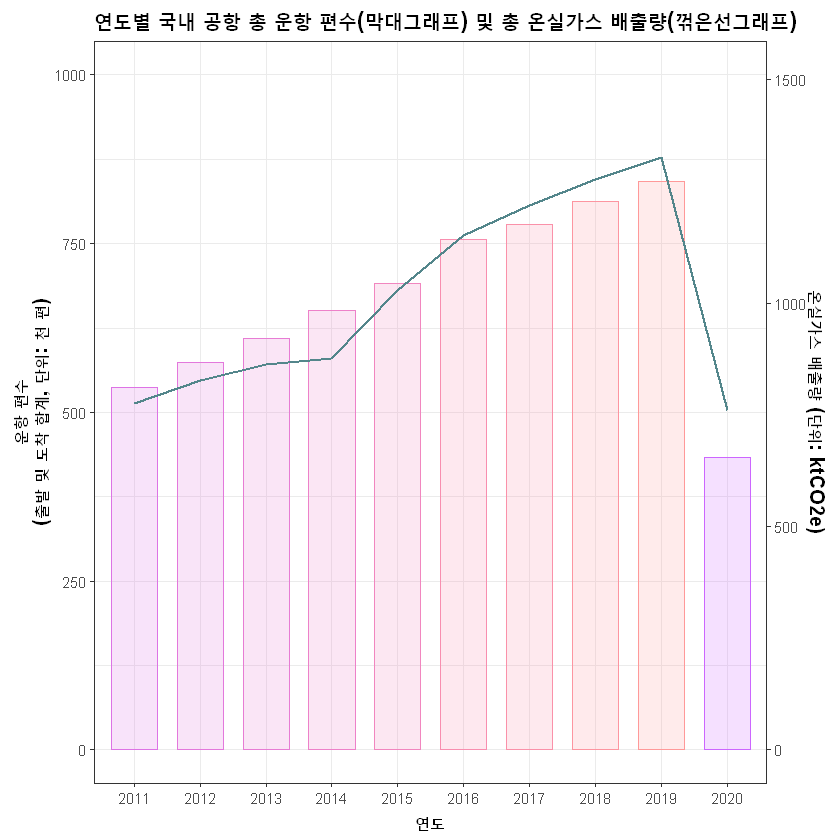

In [12]:
# 시각화용 데이터 제작
fig1Data <- inner_join(fuelData, subflgtData, by="year") %>% filter(fuelType == "온실가스총합")

# 보정값
ratio <- mean(fig1Data$subflgt)/mean(fig1Data$stats)*0.001

ggplot() + theme_bw() + 
           geom_bar(data=fig1Data,aes(x=year,y=subflgt/1000,color=subflgt, fill=subflgt),stat="identity",width=0.7,alpha=0.2) +
           geom_line(data=fig1Data,aes(x=year,y=stats*ratio),color="cadetblue4", size=0.7,group=1) +
           coord_cartesian(ylim=c(0,1000)) +
           scale_color_gradient(low="#CC66FF", high="#FF9999")+
           scale_fill_gradient(low="#CC66FF", high="#FF9999")+
           labs(title="연도별 국내 공항 총 운항 편수(막대그래프) 및 총 온실가스 배출량(꺾은선그래프)", x="연도",
                fill="운항 편수   ", color="운항 편수   ") + 
           scale_y_continuous(name = "운항 편수\n(출발 및 도착 합계, 단위: 천 편)",
                              sec.axis = sec_axis(~./ratio/1000, name="온실가스 배출량 (단위: ktCO2e)"))+
           theme(legend.position = "none",
                 title = element_text(size=12,face='bold'),
                 axis.title.x =  element_text(size=12,face='bold'),
                 axis.title.y = element_text(size=12,face='bold')
                 )

2011년부터 2019년까지 국내 항공기 온실가스 배출량이 증가하고 있음을 알 수 있습니다. 그러나 2020년 항공기 운항량의 감소로 온실가스 배출량이 급격히 하락하였습니다.

위 그래프에서 볼 수 있듯 2011년부터 2019년까지 국내 항공기 운항 편수 역시 증가했습니다. 다만 2020년 코로나19 범유행으로 운항 편수가 눈에 띄게 감소했습니다. 대체적으로 온실가스 배출량과 **양의 상관관계**에 있음을 알 수 있습니다.

### 2-1-2. 국내/국제별 총 운항 거리 (운항 편수 * 노선 거리) 변화

해당 시각화에서는 **1. 공항 온실가스 데이터**, **3. 국내/국제 항공기 운항 스케줄 데이터** 및 **4. 노선별 소요시간 및 거리 정보 데이터**를 사용했습니다.

#### 데이터 가공

In [13]:
# 국내선 데이터 가공
regData_D <- data.frame()

# 운항 일정 및 운항 요일 기반 추정운항일수 추출
for(k in 2011:2020){
    subData_FSD <- totalData_FSD %>% select("flightNum", "startCityCode", "arrivalCityCode", "startDate", "endDate",
                                                     "mon", "tue", "wed", "thu", "fri", "sat", "sun") %>%
                                                filter(format(endDate, "%Y")==as.character(k) | format(startDate, "%Y")==as.character(k))
    # 정확한 운항 일수 추출 위해 연도별 날짜 조정
    subData_FSD$revisedStartDate <- as.Date(ifelse(subData_FSD$startDate < as.Date(paste0(as.character(i),'-01-01')),
                                                format(as.Date(paste0(as.character(k),'-01-01')),"%Y-%m-%d"),
                                                format(subData_FSD$startDate, "%Y-%m-%d")))
    subData_FSD$revisedEndDate <- as.Date(ifelse(subData_FSD$endDate > paste0(as.character(i),'-12-31'),
                                              format(as.Date(paste0(as.character(k),'-12-31')),"%Y-%m-%d"),
                                              format(subData_FSD$endDate, "%Y-%m-%d")))

    # 요일별 운항일수 데이터 제작 (flightDay_FSD)
    dateInterval_FSD <- subData_FSD$revisedEndDate - subData_FSD$revisedStartDate  # 운행일수
    flightPerDay_FSD <- floor(dateInterval_FSD/7)  # 요일 당 최소운항편수 리스트
    flightAddDay_FSD <- floor((dateInterval_FSD/7 - flightPerDay_FSD)*7)  # 보정용 요일별 운항편수 리스트
    flightDay_FSD <- flightPerDay_FSD  # 요일별 운항일수 데이터
    for(i in 1:6){
        flightDay_FSD <- cbind(flightDay_FSD, flightPerDay_FSD)
    }
    colnames(flightDay_FSD) <- list(1,2,3,4,5,6,7)  # 컬럼명을 요일로 수정(1 = 월요일)
    revisedStartDate_FSD <- as.numeric(factor(weekdays(subData_FSD$revisedStartDate)))  # 항공편별 시작 요일 숫자 환산값
    for(i in 1:length(flightAddDay_FSD)){
        for(j in 0:6){
            if(j <= flightAddDay_FSD[i]){
                flightDay_FSD[i,(j+revisedStartDate_FSD[i]-1)%%7+1] <- flightDay_FSD[i,(j+revisedStartDate_FSD[i]-1)%%7+1]+1
            }
        }
    }

    # 기간 내 요일별 추정 운행일수 합산
    totalFlight_FSD <- rep(0, times=nrow(subData_FSD))
    flightWeekdays_FSD <- subData_FSD %>% select("mon","tue","wed","thu","fri","sat","sun")
    for(i in 1:nrow(subData_FSD)){
        for(j in 1:7){
            if(flightWeekdays_FSD[i,j] != "N"){
                totalFlight_FSD[i] <- totalFlight_FSD[i]+flightDay_FSD[i,j]
            }
        }
    }

    # 총 추정 운행일수 데이터를 subData_FSD에 합산
    subData_FSD$totalFlight <- totalFlight_FSD

    # 공항별 총 운항 편수(출발+도착) 추출
    ## 임시로 startCityCode가 arrivalCityCode보다 뒤면 역순, 아니면 정순으로 컬럼 새로 지정
    subData_FSD$cityCode1 <- ifelse(as.character(subData_FSD$startCityCode) <= as.character(subData_FSD$arrivalCityCode),
                                             as.character(subData_FSD$startCityCode),
                                             as.character(subData_FSD$arrivalCityCode))
    subData_FSD$cityCode2 <- ifelse(as.character(subData_FSD$startCityCode) <= as.character(subData_FSD$arrivalCityCode),
                                               as.character(subData_FSD$arrivalCityCode),
                                               as.character(subData_FSD$startCityCode))

    # 공항별 총 운항 편수(출발+도착) 추출
    subData_FSD <- subData_FSD %>% group_by(cityCode1, cityCode2) %>%
                                            summarise(totalFlight=sum(totalFlight))

    # 연도 및 국내/국제 타입 컬럼 추가
    subData_FSD$flightYear <- rep(k, times=nrow(subData_FSD))
    subData_FSD$diType <- rep("D", times=nrow(subData_FSD))

    # 출발/도착지 간 노선 거리 및 소요 시간 추가
    subData_FSD <- left_join(subData_FSD, totalData_TD, by=c("diType", "cityCode1", "cityCode2"))
    regData_D <- bind_rows(regData_D, subData_FSD)
}
# 순서 조정
regData_D <- regData_D %>% select(flightYear, cityCode1, cityCode2, diType, distance.km, time.m, totalFlight)

# 시각화 위해 운항 연도(flightYear) 타입 변경 (num -> chr)
regData_D$flightYear <- as.character(regData_D$flightYear)

head(regData_D %>% arrange(flightYear, desc(totalFlight)))

`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.


flightYear,cityCode1,cityCode2,diType,distance.km,time.m,totalFlight
2011,CJU,GMP,D,449,48,233483
2011,GMP,PUS,D,327,39,54955
2011,CJU,PUS,D,291,36,53532
2011,CJJ,CJU,D,367,42,21390
2011,GMP,RSU,D,311,38,16380
2011,CJU,KWJ,D,182,28,16365


각 컬럼의 의미는 다음과 같습니다.

|번호|컬럼명|내용
|:--- | :--- | :---
|1|flightYear|운항 연도(범위: 2011~2020년)
|2|diType|국내선 또는 국제선 구분(D: 국내선, I: 국제선)
|3|cityCode1, cityCode2|노선의 출도착 공항 코드(IATA)
|4|distance.km|출도착 공항 간 거리(단위: km)
|5|time.m|출도착 공항 간 소요 시간(단위: 분)
|**6**|**totalFlight**|**운항 일정 및 운항 요일 기반 연내 총 추정 운항 편수**(1->2 및 2->1 합계)

In [14]:
# 국제선 데이터 가공
regData_I <- data.frame()

# 운항 일정 및 운항 요일 기반 추정운항일수 추출
for(k in 2011:2020){
    subData_FSI <- totalData_FSI %>% select("flightNum", "domesticCityCode", "internationalCityCode", "startDate", "endDate",
                                                     "mon", "tue", "wed", "thu", "fri", "sat", "sun") %>%
                                                filter(format(endDate, "%Y")==as.character(k) | format(startDate, "%Y")==as.character(k))
    # 정확한 운항 일수 추출 위해 연도별 날짜 조정
    subData_FSI$revisedStartDate <- as.Date(ifelse(subData_FSI$startDate < as.Date(paste0(as.character(i),'-01-01')),
                                                format(as.Date(paste0(as.character(k),'-01-01')),"%Y-%m-%d"),
                                                format(subData_FSI$startDate, "%Y-%m-%d")))
    subData_FSI$revisedEndDate <- as.Date(ifelse(subData_FSI$endDate > paste0(as.character(i),'-12-31'),
                                              format(as.Date(paste0(as.character(k),'-12-31')),"%Y-%m-%d"),
                                              format(subData_FSI$endDate, "%Y-%m-%d")))

    # 요일별 운항일수 데이터 제작 (flightDay_FSI)
    dateInterval_FSI <- subData_FSI$revisedEndDate - subData_FSI$revisedStartDate  # 운행일수
    flightPerDay_FSI <- floor(dateInterval_FSI/7)  # 요일 당 최소운항편수 리스트
    flightAddDay_FSI <- floor((dateInterval_FSI/7 - flightPerDay_FSI)*7)  # 보정용 요일별 운항편수 리스트
    flightDay_FSI <- flightPerDay_FSI  # 요일별 운항일수 데이터
    for(i in 1:6){
        flightDay_FSI <- cbind(flightDay_FSI, flightPerDay_FSI)
    }
    colnames(flightDay_FSI) <- list(1,2,3,4,5,6,7)  # 컬럼명을 요일로 수정(1 = 월요일)
    revisedStartDate_FSI <- as.numeric(factor(weekdays(subData_FSI$revisedStartDate)))  # 항공편별 시작 요일 숫자 환산값
    for(i in 1:length(flightAddDay_FSI)){
        for(j in 0:6){
            if(j <= flightAddDay_FSI[i]){
                flightDay_FSI[i,(j+revisedStartDate_FSI[i]-1)%%7+1] <- flightDay_FSI[i,(j+revisedStartDate_FSI[i]-1)%%7+1]+1
            }
        }
    }

    # 기간 내 요일별 추정 운행일수 합산
    totalFlight_FSI <- rep(0, times=nrow(subData_FSI))
    flightWeekdays_FSI <- subData_FSI %>% select("mon","tue","wed","thu","fri","sat","sun")
    for(i in 1:nrow(subData_FSI)){
        for(j in 1:7){
            if(flightWeekdays_FSI[i,j] != "N"){
                totalFlight_FSI[i] <- totalFlight_FSI[i]+flightDay_FSI[i,j]
            }
        }
    }

    # 총 추정 운행일수 데이터를 subData_FSI에 합산
    subData_FSI$totalFlight <- totalFlight_FSI

    # 공항별 총 운항편수(출발+도착) 추출
    ## 임시로 startCityCode가 arrivalCityCode보다 뒤면 역순, 아니면 정순으로 컬럼 새로 지정
    subData_FSI$cityCode1 <- ifelse(as.character(subData_FSI$domesticCityCode) <= as.character(subData_FSI$internationalCityCode),
                                             as.character(subData_FSI$domesticCityCode),
                                             as.character(subData_FSI$internationalCityCode))
    subData_FSI$cityCode2 <- ifelse(as.character(subData_FSI$domesticCityCode) <= as.character(subData_FSI$internationalCityCode),
                                               as.character(subData_FSI$internationalCityCode),
                                               as.character(subData_FSI$domesticCityCode))

    # 공항별 총 운항편수(출발+도착) 추출
    subData_FSI <- subData_FSI %>% group_by(cityCode1, cityCode2) %>%
                                            summarise(totalFlight=sum(totalFlight))

    # 연도 및 국내/국제 타입 컬럼 추가
    subData_FSI$flightYear <- rep(k, times=nrow(subData_FSI))
    subData_FSI$diType <- rep("I", times=nrow(subData_FSI))

    # 출발/도착지 간 노선 거리 및 소요 시간 추가
    subData_FSI <- left_join(subData_FSI, totalData_TD, by=c("diType", "cityCode1", "cityCode2"))
    regData_I <- bind_rows(regData_I, subData_FSI)
}
# 순서 조정
regData_I <- regData_I %>% select(flightYear, cityCode1, cityCode2, diType, distance.km, time.m, totalFlight)

# 시각화 위해 운항 연도(flightYear) 타입 변경 (num -> chr)
regData_I$flightYear <- as.character(regData_I$flightYear)

head(regData_I %>% arrange(flightYear, desc(totalFlight)))


`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cityCode1'. You can override using the `.groups` argument.


flightYear,cityCode1,cityCode2,diType,distance.km,time.m,totalFlight
2011,GMP,HND,I,1183,103,22454
2011,GMP,KIX,I,837,77,13717
2011,GMP,SHA,I,866,79,9012
2011,NRT,PUS,I,1040,93,8974
2011,PEK,PUS,I,1215,106,7863
2011,CJU,TPE,I,1065,94,7032


각 컬럼의 의미는 다음과 같습니다.

|번호|컬럼명|내용
|:--- | :--- | :---
|1|flightYear|운항 연도(범위: 2011~2020년)
|2|diType|국내선 또는 국제선 구분(D: 국내선, I: 국제선)
|3|cityCode1, cityCode2|노선의 출도착 공항 코드(IATA)
|4|distance.km|출도착 공항 간 거리(단위: km)
|5|time.m|출도착 공항 간 소요 시간(단위: 분)
|**6**|**totalFlight**|**운항 일정 및 운항 요일 기반 연내 총 추정 운항 편수**(1->2 및 2->1 합계)

In [15]:
# 결측(na)값 빠진 데이터 변수 생성(운항 거리 통계용)
omRegData_D <- na.omit(regData_D) %>% arrange(desc(totalFlight*distance.km))
omRegData_I <- na.omit(regData_I) %>% arrange(desc(totalFlight*distance.km))

# 앞의 2개의 데이터를 regData에 합치기
regData <- data.frame()
regData <- rbind(regData, omRegData_D)
regData <- rbind(regData, omRegData_I)

# 시각화를 위해 flightYear 타입 변환(numeric -> character)
regData$flightYear <- as.character(regData$flightYear)

# 출발/도착 도시명 단일화한 컬럼 추가
regData$flightCity <- paste0(regData$cityCode1, "-", regData$cityCode2)

#### 데이터 시각화

TableGrob (4 x 9) "arrange": 5 grobs
  z     cells    name                grob
1 1 (2-2,1-9) arrange      gtable[layout]
2 2 (3-3,1-4) arrange      gtable[layout]
3 3 (3-3,5-8) arrange      gtable[layout]
4 4 (1-1,1-9) arrange text[GRID.text.163]
5 5 (4-4,1-9) arrange text[GRID.text.164]

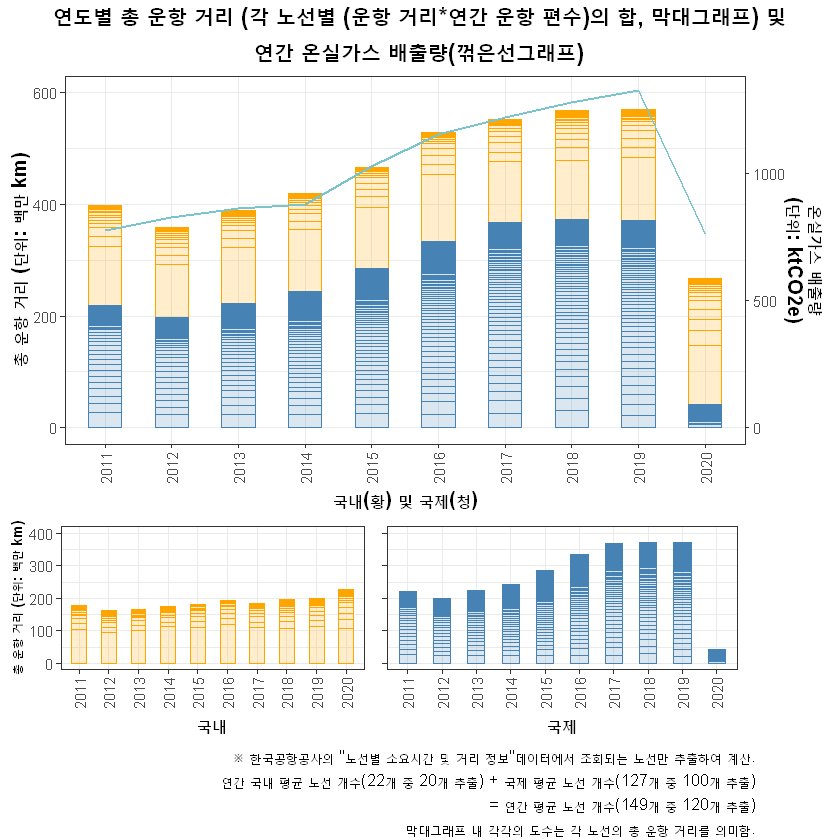

In [16]:
# 연도별 공항 온실가스 배출량 데이터 가공
gasData <- totalData_GG %>% select("yyyy", "totalTco2e")

# 온실가스 배출량 데이터 컬럼명 변경
colnames(gasData) <- c("year", "totalTco2e")

# 시각화용 데이터 제작
fig2Data <- rename(regData, "year" = "flightYear")
fig2Data <- inner_join(fig2Data, gasData, by="year")

# 시각화 시 보정용 비율
ratio <- mean(fig2Data$totalTco2e)/mean(fig2Data$totalFlight*fig2Data$distance.km)/600

# 국내 및 국제선 종합 그래프(상단)
fig2_T <- ggplot(data=fig2Data,aes(x = year, y = totalFlight*distance.km/1000000, fill=diType, color=diType)) + theme_bw() + 
           scale_fill_manual(values=c("orange","steelblue")) +
           scale_color_manual(values=c("orange","steelblue")) +
           geom_bar(stat="identity",width=0.5,size=0.005,alpha=0.2) +
           geom_line(data=fig2Data,aes(x=year,y=totalTco2e*ratio),color="cadetblue3", size=0.7,group=1) +
           labs(x="국내(황) 및 국제(청)", fill="노선 유형\n(D: 국내, I: 국제)") + 
           coord_cartesian(ylim=c(0,600)) +
           scale_y_continuous(name = "총 운항 거리 (단위: 백만 km)",
                              sec.axis = sec_axis(~./ratio/1000,
                                                  name="온실가스 배출량\n(단위: ktCO2e)"
                                                 ),
                              )+
           theme(legend.position = "none",
                 title = element_text(size=15,face='bold'),
                 axis.title.x =  element_text(size=12,face='bold'),
                 axis.title.y = element_text(size=12,face='bold'),
                 axis.text.x = element_text(angle=90,vjust = 0.5, hjust=1),
                 )

# 국내선 그래프(좌하단)
fig2_D <- ggplot(data=omRegData_D,aes(x = flightYear, y = totalFlight*distance.km/1000000, fill = totalFlight)) + theme_bw() +
           geom_bar(stat="identity",width=0.5, fill="orange", color="orange",size=0.005,alpha=0.2) +
           labs(x="국내", fill="총 운항 거리") + 
           coord_cartesian(ylim=c(0,400)) +
           scale_y_continuous(name = "총 운항 거리 (단위: 백만 km)")+
           theme(legend.position = "none",
                 title = element_text(size=15,face='bold'),
                 axis.title.x =  element_text(size=12,face='bold'),
                 axis.title.y = element_text(size=9,face='bold'),
                 axis.text.x = element_text(angle=90,vjust = 0.5, hjust=1)
                 )

# 국내선 그래프(우하단)
fig2_I <- ggplot(data=omRegData_I,aes(x = flightYear, y = totalFlight*distance.km/1000000, fill = totalFlight)) + theme_bw() +
           geom_bar(stat="identity",width=0.5, fill="steelblue", color="steelblue",size=0.005,alpha=0.2) +
           labs(x="국제", fill="총 운항 거리") + 
           coord_cartesian(ylim=c(0,400)) +
           theme(legend.position = "none",
                 title = element_text(size=14,face='bold'),
                 axis.title.x =  element_text(size=12,face='bold'),
                 axis.title.y = element_blank(),
                 axis.text.x = element_text(angle=90,vjust = 0.5, hjust=1),
                 axis.text.y = element_blank(),
                 )

fig2 <- grid.arrange(fig2_T, fig2_D, fig2_I,
                     nrow=2,
                     heights=c(2, 1),
                     layout_matrix = rbind(c(1,1,1,1,1,1,1,1,1),c(2,2,2,2,3,3,3,3,NA)),
                     top = textGrob(paste0("연도별 총 운항 거리 (각 노선별 (운항 거리*연간 운항 편수)의 합, 막대그래프) 및",
                                           "\n연간 온실가스 배출량(꺾은선그래프)"),
                                    gp = gpar(fontsize = 15, fontface = 'bold')),
                     bottom = textGrob(paste0("※ 한국공항공사의 \"노선별 소요시간 및 거리 정보\"",
                                              "데이터에서 조회되는 노선만 추출하여 계산.\n",
                                              "연간 국내 평균 노선 개수(", round(nrow(regData_D)/10),"개 중 ",
                                              round(nrow(omRegData_D)/10),"개 추출) + ",
                                              "국제 평균 노선 개수(", round(nrow(regData_I)/10),"개 중 ",
                                              round(nrow(omRegData_I)/10),"개 추출)\n",
                                              "= 연간 평균 노선 개수(", round((nrow(regData_D)+nrow(regData_I))/10),"개 중 ",
                                              round((nrow(omRegData_D)+nrow(omRegData_I))/10),"개 추출)\n",
                                              "막대그래프 내 각각의 도수는 각 노선의 총 운항 거리를 의미함."),
                                       gp = gpar(fontsize = 10), hjust=1, x=0.9))

fig2

2012년부터 2019년까지 국내 항공기 총 운항거리(국내선+국제선)가 점진적으로 증가했습니다. 반면 2011년과 2012년 사이, 2019년과 2020년 사이 국내 항공기 운항거리가 감소했습니다. 특히 2020년에는 코로나19 범유행으로 운항 거리가 크게 감소했습니다.

2-1-1 항목의 연도별 운항 편수-온실가스 간 관계와 마찬가지로 운항 거리와 온실가스 배출량이 대체적으로 비례하는 것을 볼 수 있습니다.

세부적으로 국내선과 국제선을 나눠보면, 2012년부터 2019년까지 국제선 이용이 국내선 이용보다 빠르게 증가한 것을 볼 수 있습니다. 하지만 2020년 국제선 이용은 코로나 영향으로 크게 줄어든데 반해 국내선 이용은 오히려 소폭 증가한 모습을 보였습니다. 이는 국제선 이용 규제로 인한 반사 효과로 보입니다.

### 2-1-3. 사용 항공기종 변화

해당 시각화에서는 **1. 공항 온실가스 데이터**, **5. 기종별 연료 소모량 데이터** 및 **6. 국내 공항 연도별 항공기종 사용 현황 데이터**를 사용했습니다.

#### 데이터 가공

In [17]:
# 국내 연도별 기종 사용량 변형
totalData_UA2 <- totalData_UA %>% filter(공항명 == '합계') %>% subset(select=c(-공항명, -기타, -계))

## 데이터 형태 변형
aircraftData <- data.frame()
for(i in 1:(ncol(totalData_UA2)-1)){
    subData <- data.frame(totalData_UA2[,i])
    colnames(subData) <- c("count")
    colname <- colnames(totalData_UA2)[i]
    subData$year <- 2011:2020
    subData$ICAO <- rep(colname,times=nrow(subData))
    aircraftData <- bind_rows(aircraftData, subData)
}

## 컬럼 순서 변경
aircraftData <- aircraftData %>% select(ICAO, count, year)

# 기종별 연료 사용량 변형
## 각 수치를 평균화하여 ICAO별로 요약함. (각 ICAO별로 모델을 균일하게 사용한다고 가정함.)
### 좌석별 연료 샤용량(fuelPerSeat.L.100km)의 경우 데이터가 기재되지 않은 항공기가 있어 사용하지 않음.
fuelConsDataSummarize <- totalData_FC %>% group_by(ICAO) %>% summarize(seats=mean(seats),
                                                                        fuelBurn.kg.km=mean(fuelBurn.kg.km),
                                                                        sector.nmi=mean(sector.nmi),
                                                                        sector.km=mean(sector.km))

# 연도 타입 변경
aircraftData$year <- as.character(aircraftData$year)

# 기종별 연료 사용량 데이터와 join
aircraftData <- left_join(aircraftData, fuelConsDataSummarize, by="ICAO")

# 결측치(NA)가 있는 데이터 제거
aircraftData <- na.omit(aircraftData)

# 연도별 총 항공기 연료 사용량 추가
## 모든 항공기가 최대 거리(sector)를 운항한다 가정
aircraftData$maxFuelBurn.kt <- aircraftData$count*aircraftData$fuelBurn.kg.km*aircraftData$sector.km/1000000

head(aircraftData)

ICAO,count,year,seats,fuelBurn.kg.km,sector.nmi,sector.km,maxFuelBurn.kt
B737,223751,2011,151.0909,3.126818,1040.318,1926.669,1347.953
B737,249630,2012,151.0909,3.126818,1040.318,1926.669,1503.857
B737,253812,2013,151.0909,3.126818,1040.318,1926.669,1529.051
B737,256717,2014,151.0909,3.126818,1040.318,1926.669,1546.552
B737,278528,2015,151.0909,3.126818,1040.318,1926.669,1677.949
B737,283341,2016,151.0909,3.126818,1040.318,1926.669,1706.944


각 컬럼의 의미는 다음과 같습니다. 이때 항공기종별 최대 연료 소모량 합계(maxFuelBurn.kt)은 모든 항공기가 최대 거리(sector)를 이동하는 것으로 가정한 후 계산한 값입니다.

|번호|컬럼명|내용
|:--- | :--- | :---
|1|ICAO|항공기종 코드
|2|count|같은 항공기종 코드 내 모델의 연도별 항공기종 사용량 합계(단위: 회)
|3|year|연도(범위: 2011~2020년)
|3|seats|같은 항공기종 코드 내 모델의 평균 기내 좌석 수
|4|fuelBurn.kg.km|같은 항공기종 코드 내 모델의 평균 연비(단위: kg/km)
|6|sector.nmi|같은 항공기종 코드 내 모델 최대 운항 거리의 평균(단위: nmi(해리))
|7|sector.km|같은 항공기종 코드 내 모델 최대 운항 거리의 평균(단위: km)
|**8**|**maxFuelBurn.kt**|**항공기종별 최대 연료 소모량 합계**(count * fuelBurn.kg.km * sector.km, 단위: kt)

#### 데이터 시각화

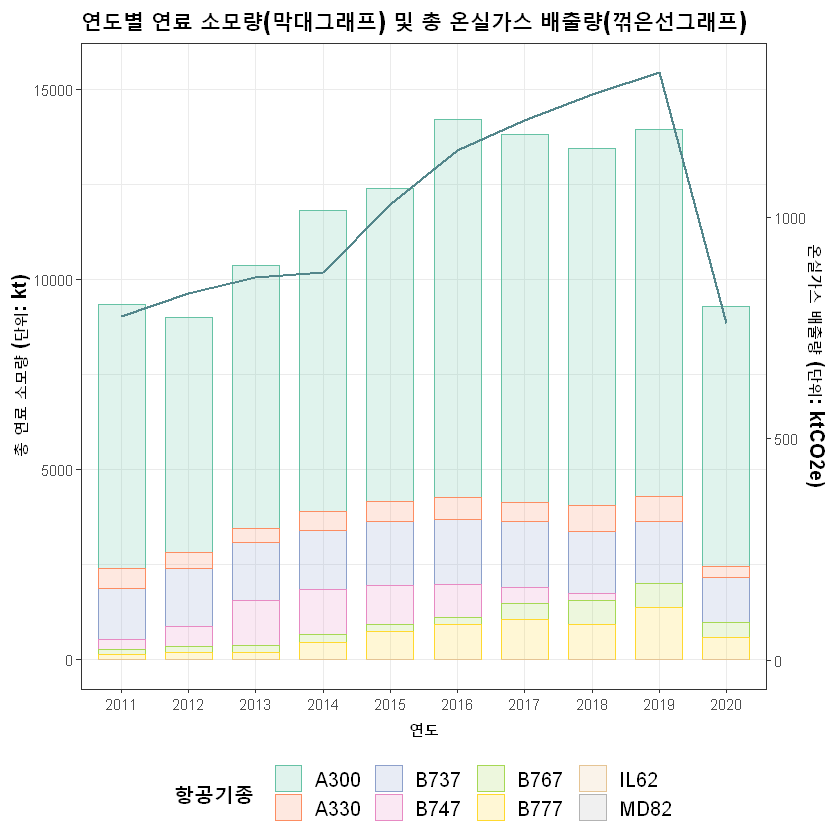

In [18]:
# 연도별 총 국내 공항(인천 포함) 출발+도착 건수 추출
gasData <- totalData_GG %>% select("yyyy", "totalTco2e")

colnames(gasData) <- c("year", "totalTco2e")

# 시각화용 데이터 제작
fig3Data <- inner_join(aircraftData, gasData, by="year")

ratio <- mean(fig3Data$maxFuelBurn.kt)/mean(fig3Data$totalTco2e) * 8

fig3 <- ggplot() + theme_bw() + 
       geom_bar(data=fig3Data,aes(x=year,y=maxFuelBurn.kt,fill=ICAO,color=ICAO),stat="identity", width=0.7,alpha=0.2) +
       geom_line(data=fig3Data,aes(x=year,y=totalTco2e*ratio),color="cadetblue4", size=0.7,group=1) +
       labs(title="연도별 연료 소모량(막대그래프) 및 총 온실가스 배출량(꺾은선그래프)", x="연도", fill="항공기종  ", color="항공기종  ") + 
       scale_y_continuous(name = "총 연료 소모량 (단위: kt)",
                          sec.axis = sec_axis(~./ratio/1000, name="온실가스 배출량 (단위: ktCO2e)"))+
       scale_color_brewer(palette = "Set2") +
       scale_fill_brewer(palette = "Set2") + 
       theme(legend.position = "bottom",
             title = element_text(size=13,face='bold'),
             axis.title.x =  element_text(size=12,face='bold'),
             axis.title.y = element_text(size=12,face='bold'),
             legend.title = element_text(size=15,face='bold', vjust=0.5),
             legend.text = element_text(size=12, vjust=0.5)
             )
fig3

연도별 총 연료 소모량은 **각 기종별 연료 소모량**에 **연간 각 기종의 운항 횟수**를 곱한 값을 더하여 구했습니다. 이때 각 기종의 연료 소모량은 노선별 사용 항공기종 공공 데이터가 없었으므로 임시적으로 기종의 **연비**에 **최대 이동 가능 거리(sector)**를 곱한 값을 이용했습니다. 또한 만일 모델이 여러 개인 항공기종의 경우 각 모델의 사용 비율이 같다고 가정, **연비의 평균**에 **최대 이동 가능 거리의 평균**을 곱한 값을 사용했습니다.

연도별 총 연료 소모량은 2012년부터 2016년까지 증가하다가 2018년과 2019년에 정체, 2020년 감소하는 형태입니다. 이렇게 연료 소모량이 들쭉날쭉한 모습을 보이는 것은 운항횟수는 증가했지만 항공기종의 변화에 따라 엔진 효율화를 이룬 결과로 비춰집니다.

### 2-1-4. 2-1-1, 2, 3 항목의 통계 결과 및 온실가스 배출량 간의 상관관계 분석

#### 데이터 가공 및 시각화

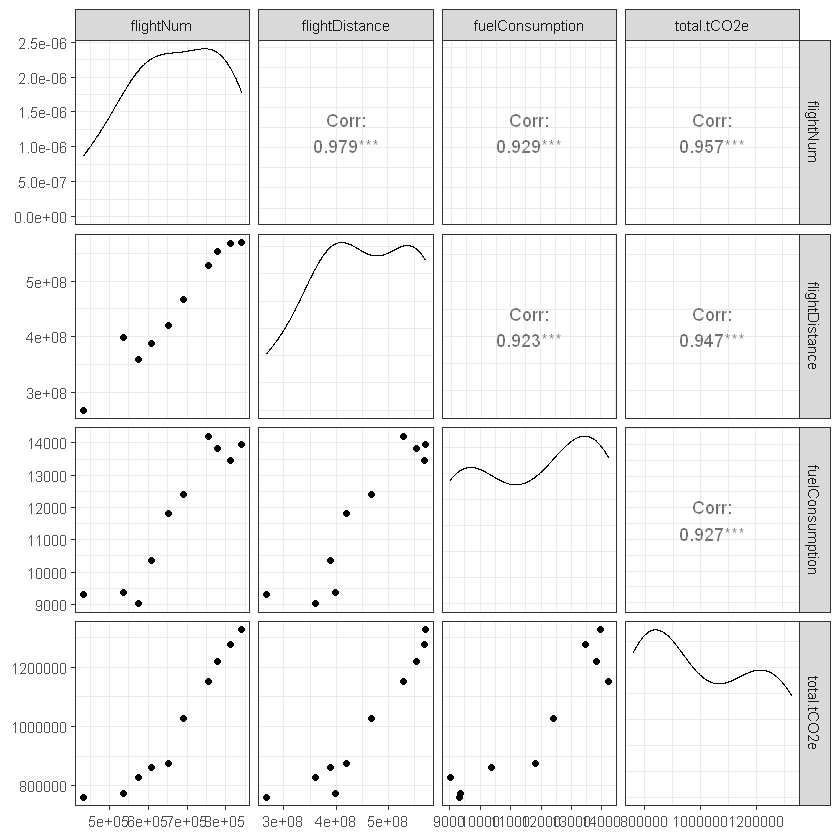

In [19]:
revisedFig1Data <- fig1Data %>% select(year,subflgt,stats) %>% rename("flightNum" = "subflgt", "total.tCO2e"="stats")
revisedFig2Data <- fig2Data %>% group_by(year) %>% summarize(flightDistance=sum(totalFlight*distance.km))
revisedFig3Data <- fig3Data %>% group_by(year) %>% summarize(fuelConsumption=sum(maxFuelBurn.kt))

fig4Data <- inner_join(revisedFig1Data, revisedFig2Data, by="year")
fig4Data <- inner_join(fig4Data, revisedFig3Data, by="year")
fig4Data <- fig4Data %>% select(-year) %>% select(flightNum, flightDistance, fuelConsumption, total.tCO2e)
fig4 <- ggpairs(fig4Data) + theme_bw()
fig4

앞에서 사용한 시각화 자료를 바탕으로 운항 편수, 운항 거리, 연료 소비량과 온실가스량 사이의 상관관계를 분석했습니다. 온실가스와 운항 편수의 상관계수는 0.957, 온실가스와 운항 거리의 상관계수는 0.948, 온실가스와 연료 소비량의 상관계수는 0.927로 산출됐습니다. 이로써 운항횟수, 운항거리, 연료소비량은 온실가스량과 비교적 뚜렷한 양의 상관관계를 가짐을 알 수 있습니다. **운항횟수, 운항거리, 연료소비량이 온실가스량을 결정하는 변수**들이라 개연적으로 추측할 수 있습니다.

이번에는 운항 편수, 운항 거리, 연료 소비량 각각의 상관관계를 살펴봅시다. 운항 편수와 운항 거리의 상관계수는 0.979, 운항 편수와 연료 소비량의 상관계수는 0.929, 운항 거리와 연료 소비량의 상관계수는 0.922입니다. 변수들 사이 상관관계가 높음을 볼 때 온실가스를 유발하는 변수들 사이의 독립성이 훼손됐다고 생각할 수 있습니다. 따라서 다중공선성이 발생해 이 세가지 변수를 이용해 **다중회귀분석을 하는 것은 적절하지 않다**는 결론이 나왔습니다.

 상관관계를 분석하고 나니 변수들 사이 상관관계가 높은 것이 당연하다는 생각이 들었습니다. 운항 횟수가 늘수록 운항거리가 늘 확률이 개연적으로 높아지고, 연료 소모량은 연비에 운항거리를 곱한 값이기 때문입니다.

## 2-2. 제언

2-1 항목에서 보았듯 항공기 운항 횟수를 줄이고 거리를 줄이면 자연히 항공기 온실가스양은 줄어들 것입니다. 하지만 무작정 항공기 운행을 규제하는 것은 현실적이지 못합니다. 따라서 제언에서는 현실을 감안해 항공기 온실가스를 줄일 수 있는 현실적 방안을 제시하고자 합니다.

### 2-2-1. 온실가스 배출량에 영향을 주는 항공기 분석

해당 분석은 **1. 공항 온실가스 데이터**에서의 *연도별 온실가스 총 배출량*과, 각 항공기종의 연비(fuelBurn)를 반영하지 않는 **6. 국내 공항 연도별 항공기종 사용 현황 데이터**에서의 *각 항공기종의 연간 사용량*을 사용합니다.

#### 데이터 가공

In [20]:
# 분석용 항공기종 데이터베이스
analysisAircraft <- data.frame()

# 연도별 총 국내 공항 총합 온실 가스 데이터 추출
gasData <- totalData_GG %>% select("yyyy", "totalTco2e")
colnames(gasData) <- c("year", "totalTco2e")

# 분석용 데이터베이스에 항공기종 데이터베이스를 다중 회귀선(1차식) 형태로 변형하여 투입
for(i in 2011:2020){
    subData <- aircraftData %>% filter(year == as.character(i)) %>% select(ICAO,count) %>% arrange(ICAO)
    colname <- subData$ICAO
    subData <- data.frame(t(subData$count))
    colnames(subData) <- colname
    subData$year <- as.character(i)
    analysisAircraft <- rbind(analysisAircraft,subData)
}
# 연도를 기준으로 gasData와 join
analysisAircraft <- inner_join(analysisAircraft, gasData, by="year")

In [21]:
# stepwise 방식으로 온실가스 배출에 영향을 주지 않는 항공기종 제거
sprintf("1. stepwise 방식으로 온실가스 배출량 예측에 적합한 변수 설정")
lmAircraft <- lm(formula = totalTco2e ~ A300 + A330 + B737 + B747 + B767 + B777 + IL62 + MD82, data = analysisAircraft)
con <- lm(totalTco2e~1,data=analysisAircraft)  # 상수항만 포함된 회귀원형
fitLmAircraft <- step(lmAircraft,scope=list(lower=con,upper=lmAircraft), direction = "both")

[1] "1. stepwise 방식으로 온실가스 배출량 예측에 적합한 변수 설정"

Start:  AIC=205.08
totalTco2e ~ A300 + A330 + B737 + B747 + B767 + B777 + IL62 + 
    MD82

       Df  Sum of Sq        RSS    AIC
- A330  1  161136583 1494206618 204.22
<none>               1333070035 205.08
- B747  1  449325110 1782395145 205.99
- B777  1  776959617 2110029652 207.67
- IL62  1 2960113917 4293183951 214.78
- B737  1 3043815320 4376885354 214.97
- MD82  1 3642043766 4975113801 216.25
- A300  1 5751887612 7084957647 219.79
- B767  1 6964534597 8297604632 221.37

Step:  AIC=204.22
totalTco2e ~ A300 + B737 + B747 + B767 + B777 + IL62 + MD82

       Df  Sum of Sq        RSS    AIC
<none>               1494206618 204.22
- B747  1  339601176 1833807794 204.27
+ A330  1  161136583 1333070035 205.08
- B777  1  647838962 2142045580 205.82
- IL62  1 3216303007 4710509624 213.71
- B737  1 3359386236 4853592854 214.00
- MD82  1 4240666540 5734873158 215.67
- B767  1 6981698114 8475904731 219.58
- A300  1 8362035324 9856241942 221.09


In [22]:
# 제거 이후 상관관계 분석 요약
sprintf("2. 불필요한 항공기종 사용량 변수(A330) 제거 이후 선형 회귀 시의 계수 요약")
summary(fitLmAircraft)$coefficients  # A300, B767이 확률 0.1 미만의 유의성을 보임

[1] "2. 불필요한 항공기종 사용량 변수(A330) 제거 이후 선형 회귀 시의 계수 요약"

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-3.628600e+05,1.349073e+05,-2.6896992,0.1148896
A300,5.412910e+00,1.617950e+00,3.3455357,0.0789137
B737,2.165464e+00,1.021201e+00,2.1205067,0.1680479
B747,5.508564e+00,8.170415e+00,0.6742086,0.5696640
B767,1.316052e+01,4.305098e+00,3.0569631,0.0924146
B777,-5.770773e+00,6.197133e+00,-0.9312005,0.4500551
IL62,-8.459262e+04,4.077034e+04,-2.0748569,0.1736871
MD82,6.395222e+02,2.684287e+02,2.3824661,0.1400857


In [23]:
# 10% 오차범위 이내 유의성을 보이는 변수(A300, B767)만 다시 상관관계 분석 요약
sprintf("3. 확률(Pr(>|t|)) 10%% 이내 유의성을 보이는 항공기종 사용량 변수만 선형 회귀 시의 계수 요약")
summary(lm(formula = totalTco2e ~ A300 + B767, data = analysisAircraft))$coefficients  # A300이 확률 0.001 미만의 유의성을 보임

[1] "3. 확률(Pr(>|t|)) 10% 이내 유의성을 보이는 항공기종 사용량 변수만 선형 회귀 시의 계수 요약"

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-57806.364474,1.498573e+05,-0.3857427,0.7111423110
A300,7.709977,1.349788e+00,5.7119924,0.0007262965
B767,9.520726,4.490242e+00,2.1203146,0.0716881925


각 컬럼의 의미는 다음과 같습니다.

항공기종 ***????***의 사용량을 ***x<sub>????</sub>***, 온실가스 배출량을 ***y***라고 했을 때, 관계식

**<center>*y = β<sub>0</sub> + β<sub>Xxyz</sub>x<sub>Xxyz</sub> + β<sub>Yabc</sub>x<sub>Yabc</sub> + ... + β<sub>Zdef</sub>x<sub>Zdef</sub>*</center>**

에서

|번호|컬럼명|내용
|:--|:--|:--
|1|Estimate|각 항공기 사용량의 추정 β값 (β<sub>0</sub>의 경우 Intercept)
|2|Std. Error|각 항공기종별 추정 β값의 표준 오차
|3|t value|각 항공기종별 추정 β값을 t분포로 정규화한 값
|4|Pr(>\|t\|)|각 항공기의 사용량이 온실가스 배출량에 **영향을 미치지 않을 확률** (β<sub>????</sub>=0일 확률)

A300, B737, B747, B767, B777, IL62, MD82 항공기종과 온실가스 배출량 사이의 다중회귀분석 결과, **온실가스 배출량에 영향을 주지 않을 확률(Pr(>|t|))이 0.1 이하**인 항공기종, 즉 온실가스 배출량과 **사실상 유의미한 상관관계**를 보이는 항공기종은 A300과 B767이었습니다. 특히 A300과 B767 두 변수를 대상으로 한 다중회귀분석을 한 결과, A300의 Pr(>|t|) 값은 약 **0.07%**로 온실가스 배출량과 상당히 높은 상관관계를 보였습니다.

### 2-2-2. 2030년 예상 노선 사용량 기반 온실가스 발생량 감소 대상 우선순위 노선 산출

해당 시각화에서는 **2-1-2. 연도 및 국내/국제 총 운항 거리 총합 비교**에서 가공된 데이터를 응용했습니다.

#### 데이터 가공

In [24]:
# 각 노선당 회귀선 요소 데이터 추출(2011~2019년 데이터 집계, 2020년은 집계 제외)
## 집계 연도가 2개 이상인 노선만 추출 (1개인 노선은 오류 발생)
fig5CityCount <- regData %>% filter(as.numeric(flightYear)<=2019) %>%
                 group_by(flightCity, diType) %>% summarize(count = n()) %>% filter(count>=2)

fig5Data <- inner_join(regData, fig5CityCount, by=c("flightCity","diType"))

# 추세선 산출 위해 연도 타입 변경(chr -> num)
fig5Data$flightYear <- as.numeric(fig5Data$flightYear)

# 노선당 추세선의 y절편(intercept) 및 기울기(slope) 산출
fig5RegressionData <- fig5Data %>% group_by(flightCity) %>%
                                    summarize(intercept = summary(lm(totalFlight~flightYear))$coefficients[1,1],
                                              slope = summary(lm(totalFlight~flightYear))$coefficients[2,1])
fig5RegressionData <- inner_join(fig5RegressionData, fig5Data %>% select(flightCity, diType), by="flightCity")

# 추세선 데이터 기반 2030년 예상값 추가
fig5RegressionData$anticipate2030 <- ifelse(fig5RegressionData$intercept+fig5RegressionData$slope*2030<0,
                                            0,fig5RegressionData$intercept+fig5RegressionData$slope*2030)

# 시각화 데이터에 적용하기 위해 데이터 형태 변경
fig5AnticiData <- fig5RegressionData %>% select(flightCity, anticipate2030,diType) %>% rename(totalFlight=anticipate2030)
fig5AnticiData$flightYear <- rep(2030, times=nrow(fig5AnticiData))

# 기존 데이터에서 노선, 총 운항 편수, 연도만 추출
fig5Data <- fig5Data %>% select(flightCity, totalFlight, flightYear, diType)

# 예상 데이터를 기존 데이터에 붙여넣기
fig5Data <- rbind(fig5Data, fig5AnticiData)

# 회귀에 사용하지 않은 데이터(2020년 데이터) 제거
fig5Data <- fig5Data %>% filter(flightYear != 2020)

# 노선 간 거리 데이터 추출
fig5DistanceData <- regData %>% select(flightCity, distance.km)
fig5DistanceData <- unique(fig5DistanceData)

# 시각화 데이터에 거리 및 국내/국제 여부 데이터 추가
fig5Data <- inner_join(fig5Data, fig5DistanceData, by = "flightCity") %>% arrange(flightCity, flightYear)

# 2030년 예상 운항 거리 상위 8개 노선 데이터만 추출
fig5Top <- head(fig5Data %>% filter(flightYear==2030) %>%
                arrange(desc(totalFlight*distance.km)) %>% distinct(flightCity,diType), 8)
fig5Top$top <- rep("o", times=nrow(fig5Top))

# 시각화 데이터에서 상위 8개 노선 데이터 추출
fig5Data <- inner_join(fig5Data, fig5Top, by =  c("flightCity","diType")) %>% select(-top)

# 노선별 추세선 작도 위해 y절편 및 기울기 데이터 추가
fig5Data <- inner_join(fig5Data, unique(fig5RegressionData),by = c("flightCity","diType")) %>% select(-anticipate2030)
fig5Data <- unique(fig5Data)

# 각 연도의 운항 편수 예측값 추가
fig5Data$anticipatedValue <- ifelse(fig5Data$intercept+fig5Data$slope*fig5Data$flightYear<0,
                                  0,fig5Data$intercept+fig5Data$slope*fig5Data$flightYear)


# 운항 거리별 정렬
fig5Data$flightCity <- factor(fig5Data$flightCity, levels = fig5Top$flightCity)

head(fig5Data %>% arrange(flightYear, flightCity))

`summarise()` has grouped output by 'flightCity'. You can override using the `.groups` argument.


flightCity,totalFlight,flightYear,diType,distance.km,intercept,slope,anticipatedValue
CJU-GMP,233483,2011,D,449,-4217969.0,2211.7273,229814.5273
GMP-PUS,54955,2011,D,327,-5917114.6,2962.8970,41271.1636
CJJ-CJU,21390,2011,D,367,-5732137.6,2858.9697,17250.4364
CJU-TAE,14864,2011,D,330,-5899342.8,2939.7879,12570.6545
GUM-PUS,388,2011,I,2884,-769768.1,382.9818,408.3818
CJU-PUS,53532,2011,D,291,-952924.9,500.0061,52587.2727


각 컬럼의 의미는 다음과 같습니다

|번호|컬럼명|내용
|:---|:---|:---
|1|flightCity|출도착 공항명
|2|totalFlight|연도별 총 운항 편수
|3|diType|국내선 또는 국제선 구분(D: 국내선, I: 국제선)
|4|distance.km|출도착 공항 간 거리(단위: km)
|5|intercept|노선별 단일선형회귀 실행 시 산출되는 **y절편**
|6|slope|노선별 단일선형회귀 실행 시 산출되는 **기울기**
|7|anticipatedValue|선형 회귀에 따른 예상값(노선별 추세선 그리기에 사용될 예정, y = intercept + slope * totalFlight)

#### 데이터 시각화

`geom_smooth()` using formula 'y ~ x'


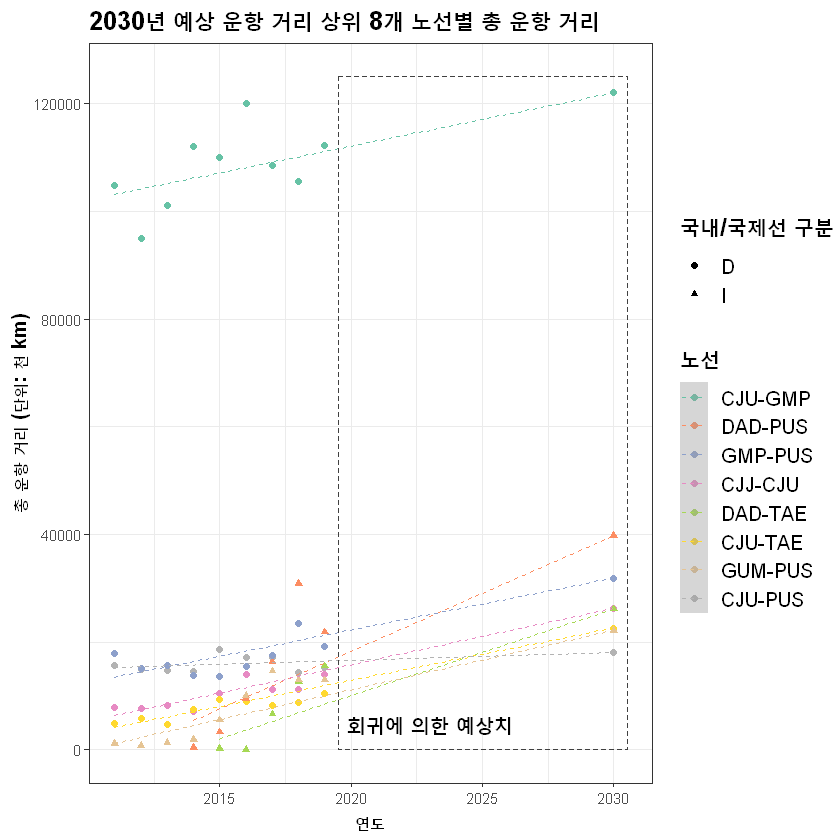

In [25]:
fig5 <- ggplot() + theme_bw() +
        geom_point(data=fig5Data, aes(x=flightYear, y=totalFlight*distance.km/1000,color=flightCity, shape=diType)) +
        geom_smooth(data=fig5Data, aes(x=flightYear, y=anticipatedValue*distance.km/1000,color=flightCity),
                    size=0.5, linetype = 2, method = "lm")+
        labs(title="2030년 예상 운항 거리 상위 8개 노선별 총 운항 거리",
             x="연도", y="총 운항 거리 (단위: 천 km)",color="노선",shape="국내/국제선 구분") + 
        #scale_x_continuous(breaks=c(2020,2030), labels) +
        scale_y_continuous(name = "총 운항 거리 (단위: 천 km)")+
        scale_color_brewer(palette = "Set2") +
        theme(legend.position = "right",
              title = element_text(size=13,face='bold'),
              axis.title.x =  element_text(size=12,face='bold'),
              axis.title.y = element_text(size=12,face='bold'),
              legend.title = element_text(size=15,face='bold', vjust=0.5),
              legend.text = element_text(size=12, vjust=0.5)
              ) + 
        annotate("rect", xmin=2019.5, xmax=2030.5, ymin=0, ymax=125000, alpha=0, color="gray25", lty="dashed") +
        annotate("text", x=2023, y=5000, label="회귀에 의한 예상치", size=5, fontface=2)

fig5

 2011년부터 2019년까지 국내 및 국제 상위 8개 노선의 총 운항 거리 데이터를 이용해 각 노선별로 선형회귀분석하여 2030년 연료소모량을 예측했습니다. 그 결과 **청주-김포 노선(CJU-GMP)**이 눈에 띄게 높은 총 운항 거리를 보였고, 다낭(베트남)-부산 노선(DAD-PUS), 김포-부산 노선(GMP-PUS)이 뒤를 이었습니다. 2020년의 데이터는 **코로나19 범유행의 특수성**을 고려해 반영하지 않았습니다. 해당 사태가 안정된다면 항공기 이용량이 기존 추세로 복귀할 것으로 예상되기 때문입니다.
 
 이렇게 **예상 연료 사용량이 높은 노선 위주**로 기존 항공기를 연비가 좋은 항공기로 대체하거나 기존 항공기의 연비를 개선하도록 개조한다면 항공기 온실가스 증가를 효과적으로 억제할 수 있을 것입니다. 실제로 최근 대한항공이 좌석수 400석의 A380의 운영을 접고 좌석당 연료 효율이 20%이상 높은 B787과 같은 항공기로 대체하였습니다 [4]. 또한 인천 국제공항에서는 기존 화석 기반 항공유를 바이오 항공유로 대체함을 통해 온실가스 배출량을 약 80% 줄일 수 있을 것이라 예상했습니다 [5]. 이러한 항공기 기종, 항공기 연료 대체를 노선 사용량이 큰 항공기 우선으로 유도한다면 정책효과를 거둘 수 있을 것입니다. 이를 유도하기 위한 방안으로 지원금, 탄소배출권 규제 등이 있을 것입니다.


# 3. 결론

## 3-1. 요약

 지금까지 항공기 운항거리, 편수, 연료 소모량과 항공기 온실가스 사이의 관계, 온실가스 변화량과 가장 연관 관계가 큰 항공기, 미래 노선별 연료 소모량 예측을 시도했습니다. 그 과정에서 
1. 운항 거리, 편수, 연료소모량과 온실가스 사이에 밀접한 **양의 상관관계**가 있음을 확인했습니다.

2. 온실가스 배출량에 밀접한 관계를 가지는 항공기는 **A300**이었습니다. 이때 A300 항공기종의 비율이 증가함에 따라 온실가스 배출량 또한 비례하여 증가하는 관계를 갖고 있습니다.

3. 청주 공항과 김포 공항 사이 2030년 운항 거리와 편수를 반영한 총 연료 소모량이 **타 노선 대비 월등히게 클 것**을 예상할 수 있었습니다. 따라서 청주 공항과 김포 공항을 이동하는 항공기 위주로 연료, 항공기 대체 작업을 한다면 온실가스 방출량을 줄일 수 있을 것입니다.

## 3-2. 한계점

### 3-2-1. 항공기종별 운항 기록 부재

공공 데이터와 누구에게나 공개된 민간 데이터 중에서는 항공기종이 기록된 운항 기록이 존재하지 않아, 항공기의 정확한 연료 소모량을 산출할 수 없는 문제점이 있었습니다. 따라서 **2-1-3. 사용 항공기종 변화** 항목에서의 **연도별 연료 소모량 그래프**를 만들 때 각 항공기종의 연비에 그 기종의 최대 이동 거리(sector)와 항공기 사용 횟수를 곱한 값으로 대체하여 나타냈습니다.

### 3-2-2. 인천국제공항공사 출처 기종별 운항 편수 데이터 부재

인천국제공항을 제외한 모든 국내 공항의 기종 사용량은 한국공항공사에서 공개한 기종별 통계를 통해 얻을 수 있었던 반면, 인천국제공항 관련 공공 데이터를 얻을 수 있는 방법이 없었습니다. 그래서 한국공항공사 출처 기종별 통계와 위키피디아 자료를 기반으로 항공기 연료 소모량을 구하여 시각화를 한 이후, 온실가스 배출량과의 상관관계를 구하였습니다 (**2-1-3. 사용 항공기종 변화** 항목 및 **2-1-4. 2-1-1, 2, 3 항목의 통계 결과 및 온실가스 배출량 간의 상관관계 분석** 항목 참조). 만일 인천국제공항공사에서 기종별 통계를 제공한다면 연료 사용량과 온실가스 배출량 사이의 식을 통해 더 정확한 항공기 연료 소모량을 산출할 수 있을 것으로 사고합니다.

### 3-2-3. 과거 실제 운항 데이터 부재

공공 데이터 중 **4) 한국공항공사의 항공기 운항정보**를 통해 실시간 운항 정보를 받을 수 있지만, **3-2-1. 항공기종별 운항 기록 부재** 항목과 마찬가지로 Flightradar24 또는 FlightAware 등의 상업용 항공 관련 데이터베이스 제공 사이트 외에는 과거 운항 데이터를 얻을 수 있는 방법이 없었습니다. 그래서 4)번 출처의 운항 스케줄로 노선별로 추정 운항 편수를 구하여 사용했습니다 (**2-1-2. 국내/국제별 총 운항 거리 변화** 항목 참조). 만일 실제 운항 데이터가 공공 데이터로 사용할 수 있다면 결항 등을 반영하여 더 정확한 운항 편수를 구할 수 있을 것으로 보입니다.

# 4. 참고 데이터 및 문헌

## 4-1. 데이터 출처
1) 한국공항공사. 공항 온실가스. OpenAPI. https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=3050602

2) 인천국제공항공사. 그린리포트. 간행물. https://www.airport.kr/co_cnt/ko/cyberpr/publicat/pbooks/pbooks.do

3) 한국공항공사. 전국공항 수송실적통계. OpenAPI. https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=3034194

4) 한국공항공사. 항공기 운항정보. OpenAPI. https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15000126

5) 한국공항공사. 노선별 소요시간 및 거리 정보. OpenAPI. https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15007809

6) Wikipedia. "Fuel economy in aircraft." https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft

7) 항공정보포털시스템. 항공기 정보 > A300. https://www.airportal.go.kr/upload/aircraft/%EC%83%81%EC%84%B8%EC%A0%95%EB%B3%B4%20-%20A300-600.pdf

8) 항공정보포털시스템. 항공기 정보 > MD-80. https://www.airportal.go.kr/upload/aircraft/%EC%83%81%EC%84%B8%EC%A0%95%EB%B3%B4%20-%20A300-600.pdf

9) 위키백과. "일류신 Il-62." https://ko.wikipedia.org/wiki/%EC%9D%BC%EB%A5%98%EC%8B%A0_Il-62

10) 한화토탈. 물질안전보건자료(MSDS). Jet A-1. https://www.hanwha-total.com/Dext/file_down?dir=product&fileName=628da97b8b0742b1af3d2fe1abcc37aa&oriFileName=GHSMSDS0591_JETA1_KR.pdf

11) 한국공항공사. 정보공개 > 항공통계 > 기종별 통계. https://www.airport.co.kr/www/cms/frFlightStatsCon/kindStats.do?MENU_ID=1250

## 문헌 출처
[1] 주희진. "국내 공항 온실가스 배출량 산정 및 저감효과 분석." 국내석사학위논문 세종대학교 일반대학원, 2016. 서울

[2] 윤태영. "공항에서 항공기(APU) 온실가스배출 저감에 관한 연구." 국내석사학위논문 한국항공대학교 대학원, 2013. 경기도

[3] 인천국제공항공사 에너지환경처, *인천국제공항공사 그린리포트 2021*, 2021, pp. 21. Available: https://www.airport.kr/co_cnt/ko/cyberpr/publicat/pbooks/pbooks.do

[4] msn 뉴스, “대한항공 ‘a380’ 등 대형기 운영 접는다…’ 연비 좋은 중형기로 대체, "기름값 아끼자" 연비좋은 중형기 도입 붐 - 매일경제 (mk.co.kr)

[5] 서울신문, “인천공항 ‘친황경 공항’ 구축 속도낸다, 인천공항 ‘친환경 공항’ 구축 속도낸다 | 서울신문 (seoul.co.kr)


본 저작물의 저작권은 Apache License v2.0을 따릅니다.